
# **Redes Neuronales Convolucionales: teoría y aplicaciones**
# Clasificación de frutas usando CNN (modelo extremo a extremo)


----

## Resumen

Con el fin de ilustrar el uso de algunas herramientas disponibles para desarrollar una CNN, se muestra la implementación de ejemplos para la clasificación de frutas y el control de calidad. Además, los mismos ejemplos se implementaron utilizando modelos conocidos previamente entrenados para ilustrar otra perspectiva de solución utilizando transferencia de aprendizaje.


----

## Descripción general

En el ejemplo, se utiliza el conjunto de datos [Fruit-360](https://github.com/Horea94/Fruit-Images-Dataset), que contiene 82213 imágenes (100 × 100 píxeles) de frutas y verduras de 120 clases, ya subdivididas en conjuntos de entrenamiento y de prueba. Específicamente, se seleccionaron seis categorías del conjunto de datos (tres tipos de manzanas y peras): Apple Golden 1, Apple Pink Lady, Apple Red 1, Pear Red, Pear Williams y Pear Monster.

Se diseña una CNN con una arquitectura bastante simple compuesta por la capa de entrada, tres capas convolucionales, una capa de aplanamiento, una capa completamente conectada y la capa de salida.

##**¡¡Manos a la obra!!**

In [ ]:
import os 																			                                # for manipulating the directories
import cv2 																			                                # for image processing
import random 																		                              # for shuffling
import numpy as np 																	                            # for array manipulating and scientific computing
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf 															                          # for more details see: https://www.tensorflow.org/tutorials
from tensorflow import keras 														                        # for more details see: https://www.tensorflow.org/guide/keras/overview

from tensorflow.keras.models import Model 								                      # for more details see about Model class API: https://keras.io/models/model/
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical				       				          # for categorical labels
from tensorflow.keras import optimizers

In [ ]:
# general parameters
NAME = 'fruits-classifier'                                                      # name for the callback output
base_dir = "datasets/fruits-360/"	                                              # directory path of the fruit dataset, download from: https://github.com/Horea94/Fruit-Images-Dataset (Horea Muresan, Mihai Oltean, Fruit recognition from images using deep learning, Acta Univ. Sapientiae, Informatica Vol. 10, Issue 1, pp. 26-42, 2018.)
CATEGORIES = ["Apple Golden 1","Apple Pink Lady","Apple Red 1","Pear Red","Pear Williams","Pear Monster"] 	# we work with three classes of Apple and Pear
class_names = CATEGORIES
num_classes = 6
img_size = 100

In [ ]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset.git

!ls

base_dir = 'Fruit-Images-Dataset/'

!ls Fruit-Images-Dataset/

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8659/8659), done.
remote: Total 385858 (delta 37), reused 8688 (delta 34), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 30.68 MiB/s, done.
Resolving deltas: 100% (1197/1197), done.
Updating files: 100% (90503/90503), done.
Fruit-Images-Dataset  sample_data
LICENSE  papers  readme.md  src  Test  test-multiple_fruits  Training


In [ ]:
!ls Fruit-Images-Dataset/Training/

'Apple Braeburn'        Clementine	    Mangostan		  Pineapple
'Apple Crimson Snow'    Cocos		    Maracuja		 'Pineapple Mini'
'Apple Golden 1'        Corn		   'Melon Piel de Sapo'  'Pitahaya Red'
'Apple Golden 2'       'Corn Husk'	    Mulberry		  Plum
'Apple Golden 3'       'Cucumber Ripe'	    Nectarine		 'Plum 2'
'Apple Granny Smith'   'Cucumber Ripe 2'   'Nectarine Flat'	 'Plum 3'
'Apple Pink Lady'       Dates		   'Nut Forest'		  Pomegranate
'Apple Red 1'	        Eggplant	   'Nut Pecan'		 'Pomelo Sweetie'
'Apple Red 2'	        Fig		   'Onion Red'		 'Potato Red'
'Apple Red 3'	       'Ginger Root'	   'Onion Red Peeled'	 'Potato Red Washed'
'Apple Red Delicious'   Granadilla	   'Onion White'	 'Potato Sweet'
'Apple Red Yellow 1'   'Grape Blue'	    Orange		 'Potato White'
'Apple Red Yellow 2'   'Grapefruit Pink'    Papaya		  Quince
 Apricot	       'Grapefruit White'  'Passion Fruit'	  Rambutan
 Avocado	       'Grape Pink'	    Peach		  Raspberry
'Avocado ripe'	       'Grape White'	   'Peach

In [ ]:
# Read training set
train_images = []
train_dir = os.path.join(base_dir, 'Training/')										              # set the training directory in the path

for category in CATEGORIES:															                        # iterate to each category
    path = os.path.join(train_dir, category)
    class_num = CATEGORIES.index(category)
    for image in os.listdir(path):													                    # iterate to each image in the category
        if(image.endswith('jpg') and not image.startswith('.')):
            img_array = cv2.imread(os.path.join(path,image),                    # read the image
                              cv2.IMREAD_GRAYSCALE)
            train_images.append([img_array, class_num])								          # save the image in training data array

print("Training images: ", len(train_images))

Training images:  3074


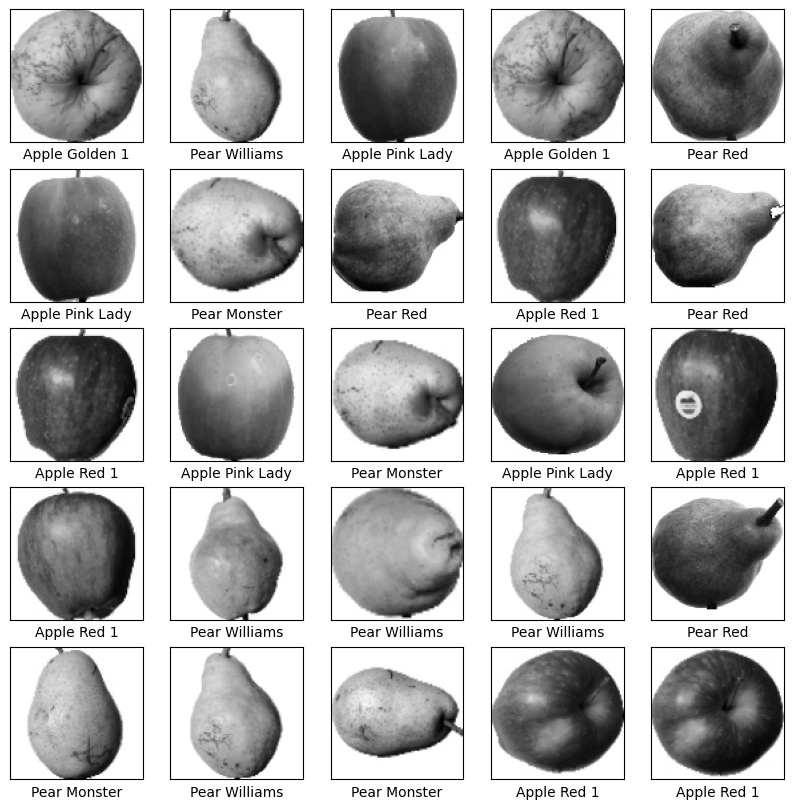

In [ ]:
import random
img_idx = random.sample(range(len(train_images)), 25)
img_idx = np.array(img_idx)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[img_idx[i]][0], cmap='gray')
    plt.xlabel(class_names[train_images[img_idx[i]][1]])
plt.show()

In [ ]:
# Read testing set
test_images = []
test_dir = os.path.join(base_dir, 'Test/')											                # set the test directory in the path

for category in CATEGORIES:															                        # iterate to each category
    path = os.path.join(test_dir, category)
    class_num = CATEGORIES.index(category)
    for image in os.listdir(path):													                    # iterate to each image in the category
        if(image.endswith('jpg') and not image.startswith('.')):
            img_array = cv2.imread(os.path.join(path,image),                    # read the image
                                   cv2.IMREAD_GRAYSCALE)
            test_images.append([img_array, class_num])								          # save the image in test data array

print("Testing images: ", len(test_images))

Testing images:  1030


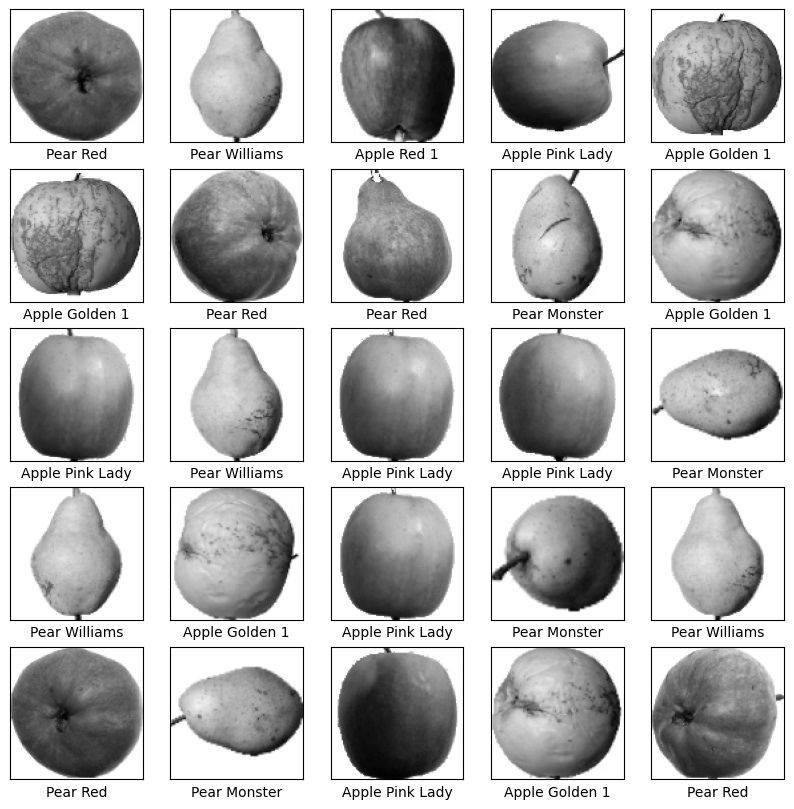

In [ ]:
import random
img_idx = random.sample(range(len(test_images)), 25)
img_idx = np.array(img_idx)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[img_idx[i]][0], cmap='gray')
    plt.xlabel(class_names[test_images[img_idx[i]][1]])
plt.show()

In [ ]:
# Shuffle the dataset before training for better accuracy
x_train = []																		                                # array for images
y_train = []																		                                # array for labels

random.shuffle(train_images)														                        # shuffle training images

for features, label in train_images: 												                    # iterate to each image and the corresponding label in training data
	x_train.append(features)
	y_train.append(label)
x_train = np.array(x_train)

x_test = []																			                                # array for images
y_test = []																			                                # array for labels

random.shuffle(test_images) 														                        # shuffle testing images

for features, label in test_images: 												                    # iterate to each image and the corresponding label in training data
	x_test.append(features)
	y_test.append(label)
x_test = np.array(x_test)

In [ ]:
# reshape and normalize the data before training
x_train = x_train.reshape(-1, img_size, img_size, 1)
mean_train = np.mean(x_train, axis=0)
x_train = x_train-mean_train
x_train = x_train/255

x_test = x_test.reshape(-1, img_size, img_size, 1)
mean_test = np.mean(x_test, axis=0)
x_test = x_test-mean_test
x_test = x_test/255

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

print(x_train.shape)
print(x_test.shape)

(3074, 100, 100, 1)
(1030, 100, 100, 1)


In [ ]:
# Hyperparameters settings
input_shape = x_train.shape[1:]
filters_numbers = [16, 32, 64]
filters_size = [[5,5],[4,4],[3,3]]

pool_size=(2, 2)
weight_decay = 5e-4
dropout = 0.6
lr = 0.001
momentum = 0.9

epochs = 10
batch_size = 32

L2_norm = keras.regularizers.l2(weight_decay)

In [ ]:
# Setup model layers

# Input layer
model_input = Input(shape=input_shape)

# 1st Convolutional layer
model_output = Conv2D(filters_numbers[0], kernel_size=(filters_size[0]), kernel_regularizer=L2_norm, padding="Same",
							activation='relu', data_format='channels_last')(model_input)

model_output = BatchNormalization()(model_output)

model_output = MaxPooling2D(pool_size=(pool_size))(model_output)

# 2nd Convolutional layer
model_output = Conv2D(filters_numbers[1], kernel_size=(filters_size[1]), kernel_regularizer=L2_norm, padding="Same",
							activation='relu', data_format='channels_last')(model_output)

model_output = BatchNormalization()(model_output)

model_output = MaxPooling2D(pool_size=(pool_size))(model_output)

# 3rd Convolutional layer
model_output = Conv2D(filters_numbers[2], kernel_size=(filters_size[2]), kernel_regularizer=L2_norm, padding="Same",
							activation='relu', data_format='channels_last')(model_output)

model_output = BatchNormalization()(model_output)

model_ouput = GlobalAveragePooling2D(data_format='channels_last')(model_output)

# Convert features to flatten vector
model_output = Flatten()(model_output)

# Full-connected layer
model_output = Dense(512)(model_output)
model_output = Dropout(dropout)(model_output)

# Output layer
model_output = Dense(num_classes, activation='softmax', name='id')(model_output)

# Create the Model by using Input and Output layers
model = Model(inputs=model_input, outputs=model_output, name=NAME)

# Show the Model summary information
model.summary()

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizers.SGD(lr, momentum), metrics=['accuracy'])

Model: "fruits-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      416       
                                                                 
 batch_normalization (Batch  (None, 100, 100, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        8224      
                                                                 
 batch_normalization_1 (Bat  (None, 50, 50, 32)  

In [ ]:
# Train the model
print("[INFO] Train the model on training data")

history = model.fit(x=x_train, y=np.asarray(y_train), batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

[INFO] Train the model on training data
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


87/87 [==============================] - 78s 868ms/step - loss: 0.2925 - accuracy: 0.9487 - val_loss: 4.6977 - val_accuracy: 0.1818
Epoch 2/10
87/87 [==============================] - 67s 768ms/step - loss: 0.0409 - accuracy: 0.9975 - val_loss: 6.4283 - val_accuracy: 0.1818
Epoch 3/10
87/87 [==============================] - 70s 801ms/step - loss: 0.0611 - accuracy: 0.9949 - val_loss: 3.9813 - val_accuracy: 0.3019
Epoch 4/10
87/87 [==============================] - 73s 842ms/step - loss: 0.0367 - accuracy: 0.9989 - val_loss: 2.3380 - val_accuracy: 0.6039
Epoch 5/10
87/87 [==============================] - 67s 777ms/step - loss: 0.0391 - accuracy: 0.9993 - val_loss: 0.7856 - val_accuracy: 0.8344
Epoch 6/10
87/87 [==============================] - 72s 830ms/step - loss: 0.0501 - accuracy: 0.9957 - val_loss: 1.0077 - val_accuracy: 0.8636
Epoch 7/10
87/87 [==============================] - 71s 817ms/step - loss: 0.0349 - accuracy: 0.9996 - val_loss: 0.0359 - val_accuracy: 1.0000
Epoch 8/10

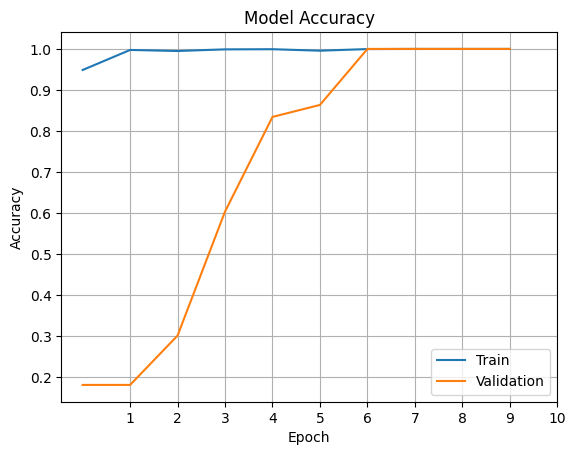

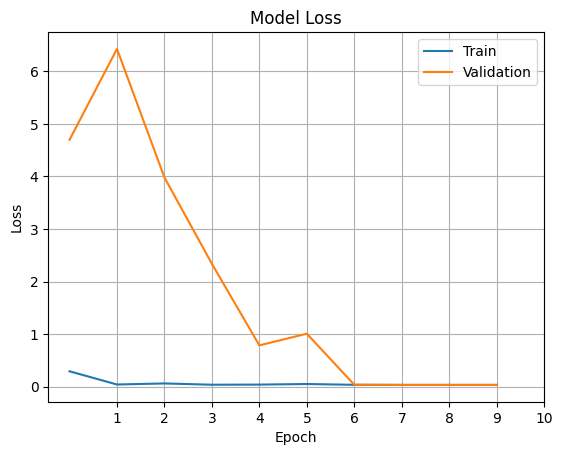

In [ ]:
# Plot training curves
x = [1,2,3,4,5,6,7,8,9,10]
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(x)
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(which='major', axis='both')
plt.savefig('fruits_classifier-training_acc.png')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(x)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(which='major', axis='both')

plt.savefig('fruits_classifier-training_loss.png')
plt.show()

In [ ]:
# Test the model
print("[INFO] Evaluate the test data")

results = model.evaluate(x=x_test, y=y_test, batch_size=batch_size, verbose=1)
print('Testing Loss, Testing Acc: ', [round(r,4) for r in results])

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

print('Accuracy', round(accuracy_score(y_test, y_pred),4))
print('Classification report', classification_report(y_test, y_pred, target_names=class_names))

[INFO] Evaluate the test data
33/33 [==============================] - 9s 265ms/step - loss: 0.0602 - accuracy: 0.9883
Testing Loss, Testing Acc:  [0.0602, 0.9883]
33/33 [==============================] - 7s 202ms/step
Accuracy 0.9883
Classification report                  precision    recall  f1-score   support

 Apple Golden 1       1.00      0.93      0.96       160
Apple Pink Lady       1.00      1.00      1.00       152
    Apple Red 1       1.00      1.00      1.00       164
       Pear Red       1.00      1.00      1.00       222
  Pear Williams       1.00      1.00      1.00       166
   Pear Monster       0.93      1.00      0.97       166

       accuracy                           0.99      1030
      macro avg       0.99      0.99      0.99      1030
   weighted avg       0.99      0.99      0.99      1030



Ejemplos de mapas de activación de la tercera capa de convolución:

![CNN-architecture](https://drive.google.com/uc?id=1tx8PouEyoYM6mN1CM-vhsvGUNgu_i6fI)

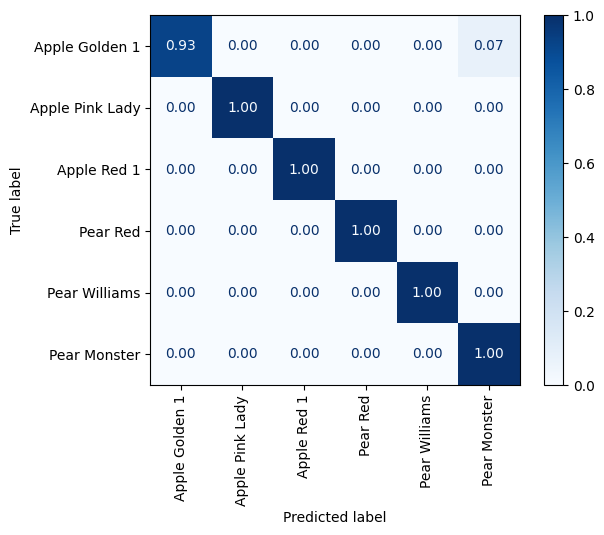

In [ ]:
# Plot Testing confusion matrix
cmat = confusion_matrix(np.asarray(y_test), y_pred, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical', values_format='.2f')
plt.show()
